In [ ]:
# Cell 1: Setup & imports the libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
import torchvision
from torchvision import transforms, datasets, models

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


100%|██████████| 26.4M/26.4M [00:02<00:00, 9.88MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 184kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.31MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 31.2MB/s]


Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Training counts: {'T-shirt/top': np.int64(6000), 'Trouser': np.int64(6000), 'Pullover': np.int64(6000), 'Dress': np.int64(6000), 'Coat': np.int64(6000), 'Sandal': np.int64(6000), 'Shirt': np.int64(6000), 'Sneaker': np.int64(6000), 'Bag': np.int64(6000), 'Ankle boot': np.int64(6000)}


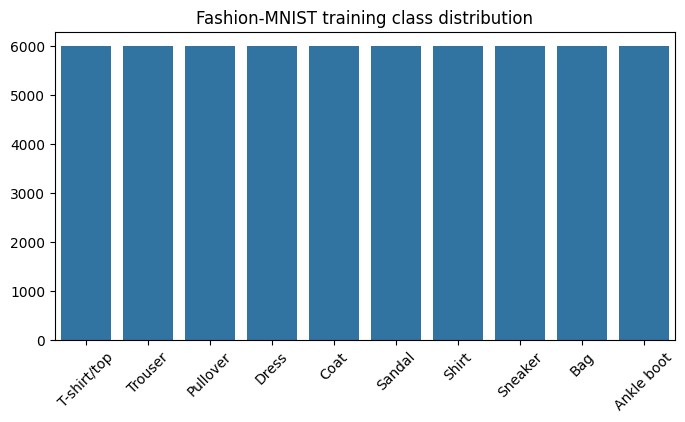

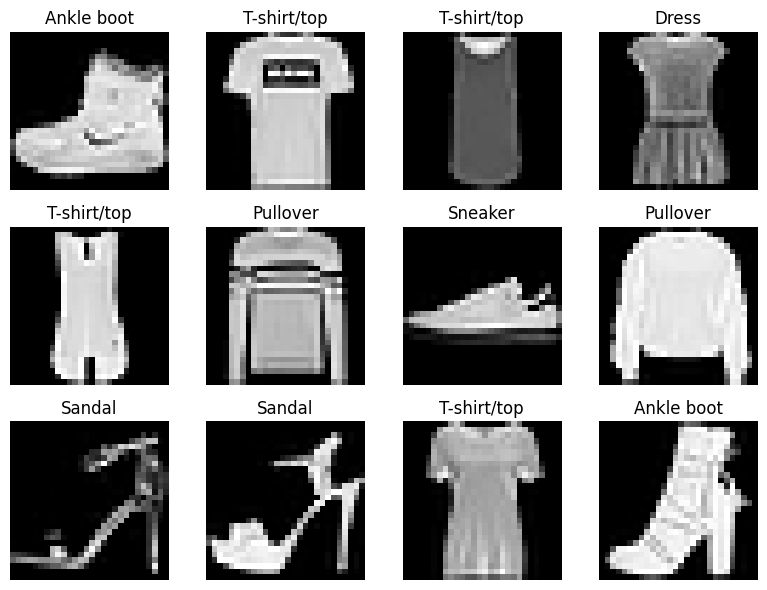

In [ ]:
# Cell 2: Load raw dataset and quick EDA(Exploratory Data Analysis)
root = './data'
train_full_raw = torchvision.datasets.FashionMNIST(root=root, train=True, download=True)
test_full_raw  = torchvision.datasets.FashionMNIST(root=root, train=False, download=True)

class_names = train_full_raw.classes
print("Classes:", class_names)

labels_train = np.array(train_full_raw.targets)
labels_test  = np.array(test_full_raw.targets)
unique, counts = np.unique(labels_train, return_counts=True)
print("Training counts:", dict(zip(class_names, counts)))

plt.figure(figsize=(8,4))
sns.barplot(x=class_names, y=counts)
plt.xticks(rotation=45)
plt.title("Fashion-MNIST training class distribution")
plt.show()

plt.figure(figsize=(8,6))
for i in range(12):
    img, label = train_full_raw[i]
    plt.subplot(3,4,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(class_names[label])
    plt.axis('off')
plt.tight_layout()


In [ ]:
# Cell 3: Transforms and  Data Augmentation
# Small networks (MLP, CNN) use 28x28; ConvNeXt uses 224x224 with ImageNet Normalization.

mean_small, std_small = 0.5, 0.5
imagenet_mean = [0.485]
imagenet_std  = [0.229]

# Small model transforms (MLP/CNN)
train_transform_small = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.08,0.08), scale=(0.95,1.05)),
    transforms.ToTensor(),
    transforms.Normalize((mean_small,), (std_small,))
])
test_transform_small = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean_small,), (std_small,))
])

# ConvNeXt transforms (stronger augmentation + resize to 224)
train_transform_convnext = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(0, shear=6, scale=(0.9,1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.12))
])
test_transform_convnext = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])


In [ ]:
# Cell 4: Create datasets and splits the data into test, train and validation (80/20 on training)
# We'll create separate Subset datasets with appropriate transforms for small models and ConvNeXt.

full_dataset = torchvision.datasets.FashionMNIST(root=root, train=True, transform=train_transform_small, download=False)
test_dataset_small = torchvision.datasets.FashionMNIST(root=root, train=False, transform=test_transform_small, download=False)
test_dataset_convnext = torchvision.datasets.FashionMNIST(root=root, train=False, transform=test_transform_convnext, download=False)

# split indices
train_size = int(0.8 * len(full_dataset))  # 48000
val_size = len(full_dataset) - train_size  # 12000
train_subset, val_subset = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))
train_indices = train_subset.indices
val_indices = val_subset.indices

# Build datasets with correct transforms
train_dataset_small = Subset(torchvision.datasets.FashionMNIST(root=root, train=True, transform=train_transform_small, download=False), train_indices)
val_dataset_small   = Subset(torchvision.datasets.FashionMNIST(root=root, train=True, transform=test_transform_small, download=False), val_indices)

train_dataset_convnext = Subset(torchvision.datasets.FashionMNIST(root=root, train=True, transform=train_transform_convnext, download=False), train_indices)
val_dataset_convnext   = Subset(torchvision.datasets.FashionMNIST(root=root, train=True, transform=test_transform_convnext, download=False), val_indices)

print("Sizes -> train:", len(train_dataset_small), "val:", len(val_dataset_small), "test:", len(test_dataset_small))


Sizes -> train: 48000 val: 12000 test: 10000


In [ ]:
# Cell 5: DataLoaders & batchsize
batch_size_small = 128
batch_size_conv = 64

train_loader_small = DataLoader(train_dataset_small, batch_size=batch_size_small, shuffle=True, num_workers=2, pin_memory=True)
val_loader_small   = DataLoader(val_dataset_small, batch_size=batch_size_small, shuffle=False, num_workers=2, pin_memory=True)
test_loader_small  = DataLoader(test_dataset_small, batch_size=batch_size_small, shuffle=False, num_workers=2, pin_memory=True)

train_loader_conv = DataLoader(train_dataset_convnext, batch_size=batch_size_conv, shuffle=True, num_workers=2, pin_memory=True)
val_loader_conv   = DataLoader(val_dataset_convnext, batch_size=batch_size_conv, shuffle=False, num_workers=2, pin_memory=True)
test_loader_conv  = DataLoader(test_dataset_convnext, batch_size=batch_size_conv, shuffle=False, num_workers=2, pin_memory=True)


In [ ]:
# Cell 6: Utility Function (train/validate/evaluate/plots)
def train_one_epoch(model, dataloader, criterion, optimizer, device, scaler=None, scheduler=None):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        if scaler is not None:
            with torch.cuda.amp.autocast():
                outputs = model(imgs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        if scheduler is not None:
            try:
                scheduler.step()
            except Exception:
                pass
        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total

def evaluate(model, dataloader, criterion, device, return_preds=False):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            probs = nn.functional.softmax(outputs, dim=1)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.append(preds.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    if not return_preds:
        return running_loss / total, correct / total
    else:
        return running_loss / total, correct / total, np.concatenate(all_preds), np.concatenate(all_probs), np.concatenate(all_labels)

def plot_train_val_curves(history, title='Loss/Accuracy'):
    epochs = len(history['train_loss'])
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].plot(range(1,epochs+1), history['train_loss'], label='train_loss')
    ax[0].plot(range(1,epochs+1), history['val_loss'], label='val_loss')
    ax[0].set_title('Loss'); ax[0].legend()
    ax[1].plot(range(1,epochs+1), history['train_acc'], label='train_acc')
    ax[1].plot(range(1,epochs+1), history['val_acc'], label='val_acc')
    ax[1].set_title('Accuracy'); ax[1].legend()
    fig.suptitle(title)
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion matrix'):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True'); plt.xlabel('Predicted'); plt.title(title)
    plt.xticks(rotation=45); plt.yticks(rotation=0)
    plt.show()

def per_class_metrics(y_true, y_pred, classes):
    print(classification_report(y_true, y_pred, target_names=classes, digits=4))


In [ ]:
# Cell 7: Simple MLP(Multilayer perceptron)
class SimpleMLP(nn.Module):
    def __init__(self, input_size=28*28, hidden_sizes=[512,256], num_classes=10, activation='silu', dropout_p=0.4):
        super().__init__()
        act = self._get_activation(activation)
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, hidden_sizes[0]),
            act,
            nn.Dropout(dropout_p),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            act,
            nn.Dropout(dropout_p),
            nn.Linear(hidden_sizes[1], num_classes)
        )
    def _get_activation(self, name):
        if name.lower() == 'relu':
            return nn.ReLU()
        elif name.lower() == 'leakyrelu':
            return nn.LeakyReLU(0.1)
        elif name.lower() == 'gelu':
            return nn.GELU()
        elif name.lower() in ('silu','swish'):
            return nn.SiLU()
        else:
            return nn.ReLU()
    def forward(self, x):
        return self.net(x)

mlp = SimpleMLP(activation='silu').to(device)
print(mlp)


SimpleMLP(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): SiLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): SiLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=256, out_features=10, bias=True)
  )
)


[MLP] Epoch 1/12 -> train_acc=0.6833, val_acc=0.7663
[MLP] Epoch 2/12 -> train_acc=0.7431, val_acc=0.7961
[MLP] Epoch 3/12 -> train_acc=0.7600, val_acc=0.8113
[MLP] Epoch 4/12 -> train_acc=0.7698, val_acc=0.8171
[MLP] Epoch 5/12 -> train_acc=0.7799, val_acc=0.8171
[MLP] Epoch 6/12 -> train_acc=0.7840, val_acc=0.8266
[MLP] Epoch 7/12 -> train_acc=0.7880, val_acc=0.8326
[MLP] Epoch 8/12 -> train_acc=0.8027, val_acc=0.8443
[MLP] Epoch 9/12 -> train_acc=0.8085, val_acc=0.8483
[MLP] Epoch 10/12 -> train_acc=0.8104, val_acc=0.8516
[MLP] Epoch 11/12 -> train_acc=0.8123, val_acc=0.8502
[MLP] Epoch 12/12 -> train_acc=0.8137, val_acc=0.8528


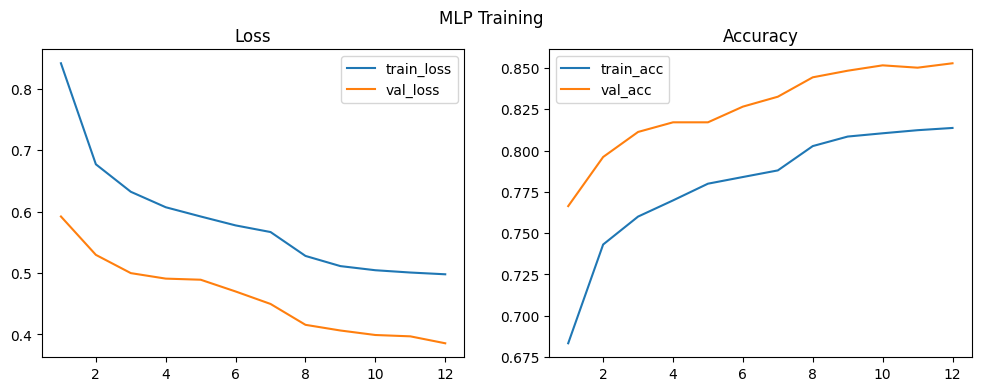

In [ ]:
# Cell 8: Train MLP(Multilayer perceptron) (quick)
criterion = nn.CrossEntropyLoss()
mlp = SimpleMLP(activation='silu', dropout_p=0.4).to(device)
optimizer = optim.AdamW(mlp.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

mlp_epochs = 12
history_mlp = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}
best_val_acc = 0
best_state = None

for epoch in range(1, mlp_epochs+1):
    train_loss, train_acc = train_one_epoch(mlp, train_loader_small, criterion, optimizer, device)
    val_loss, val_acc = evaluate(mlp, val_loader_small, criterion, device)
    scheduler.step()
    history_mlp['train_loss'].append(train_loss); history_mlp['train_acc'].append(train_acc)
    history_mlp['val_loss'].append(val_loss); history_mlp['val_acc'].append(val_acc)
    print(f"[MLP] Epoch {epoch}/{mlp_epochs} -> train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = mlp.state_dict()

if best_state is not None:
    mlp.load_state_dict(best_state)

plot_train_val_curves(history_mlp, title='MLP Training')


MLP Test acc: 0.8487


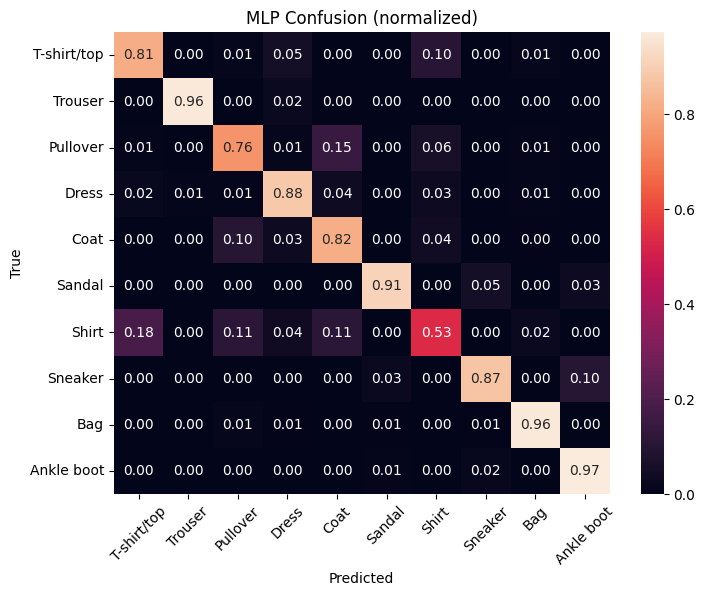

              precision    recall  f1-score   support

 T-shirt/top     0.7897    0.8150    0.8022      1000
     Trouser     0.9827    0.9640    0.9732      1000
    Pullover     0.7515    0.7560    0.7537      1000
       Dress     0.8427    0.8840    0.8629      1000
        Coat     0.7314    0.8170    0.7718      1000
      Sandal     0.9509    0.9110    0.9305      1000
       Shirt     0.6838    0.5320    0.5984      1000
     Sneaker     0.9218    0.8720    0.8962      1000
         Bag     0.9396    0.9640    0.9516      1000
  Ankle boot     0.8780    0.9720    0.9226      1000

    accuracy                         0.8487     10000
   macro avg     0.8472    0.8487    0.8463     10000
weighted avg     0.8472    0.8487    0.8463     10000



In [ ]:
# Cell 9: Evaluate MLP(Multilayer perceptron) on test & confusion metrics
test_loss_mlp, test_acc_mlp, y_pred_mlp, y_prob_mlp, y_true_mlp = evaluate(mlp, test_loader_small, criterion, device, return_preds=True)
print("MLP Test acc:", test_acc_mlp)
plot_confusion_matrix(y_true_mlp, y_pred_mlp, class_names, normalize=True, title='MLP Confusion (normalized)')
per_class_metrics(y_true_mlp, y_pred_mlp, class_names)


In [ ]:
# Cell 10: Simple CNN(Convolutional neural network)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10, activation='silu', dropout_p=0.3):
        super().__init__()
        act = self._get_activation(activation)
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            act,
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            act,
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            act,
            nn.AdaptiveAvgPool2d((3,3))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*3*3, 256),
            act,
            nn.Dropout(dropout_p),
            nn.Linear(256, num_classes)
        )
    def _get_activation(self, name):
        if name.lower() == 'relu':
            return nn.ReLU()
        elif name.lower() == 'leakyrelu':
            return nn.LeakyReLU(0.1)
        elif name.lower() == 'gelu':
            return nn.GELU()
        elif name.lower() in ('silu','swish'):
            return nn.SiLU()
        else:
            return nn.ReLU()
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

cnn = SimpleCNN(activation='silu').to(device)
print(cnn)


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): SiLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): SiLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): SiLU()
    (8): AdaptiveAvgPool2d(output_size=(3, 3))
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1152, out_features=256, bias=True)
    (2): SiLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)


[CNN] Epoch 1/18 -> train_acc=0.3679, val_acc=0.6907
[CNN] Epoch 2/18 -> train_acc=0.6857, val_acc=0.7351
[CNN] Epoch 3/18 -> train_acc=0.7340, val_acc=0.7528
[CNN] Epoch 4/18 -> train_acc=0.7544, val_acc=0.7629
[CNN] Epoch 5/18 -> train_acc=0.7669, val_acc=0.7927
[CNN] Epoch 6/18 -> train_acc=0.7778, val_acc=0.7967
[CNN] Epoch 7/18 -> train_acc=0.7881, val_acc=0.8185
[CNN] Epoch 8/18 -> train_acc=0.7982, val_acc=0.8197
[CNN] Epoch 9/18 -> train_acc=0.8109, val_acc=0.8293
[CNN] Epoch 10/18 -> train_acc=0.8174, val_acc=0.8383
[CNN] Epoch 11/18 -> train_acc=0.8259, val_acc=0.8442
[CNN] Epoch 12/18 -> train_acc=0.8305, val_acc=0.8566
[CNN] Epoch 13/18 -> train_acc=0.8368, val_acc=0.8557
[CNN] Epoch 14/18 -> train_acc=0.8425, val_acc=0.8607
[CNN] Epoch 15/18 -> train_acc=0.8459, val_acc=0.8736
[CNN] Epoch 16/18 -> train_acc=0.8528, val_acc=0.8717
[CNN] Epoch 17/18 -> train_acc=0.8552, val_acc=0.8704
[CNN] Epoch 18/18 -> train_acc=0.8602, val_acc=0.8768


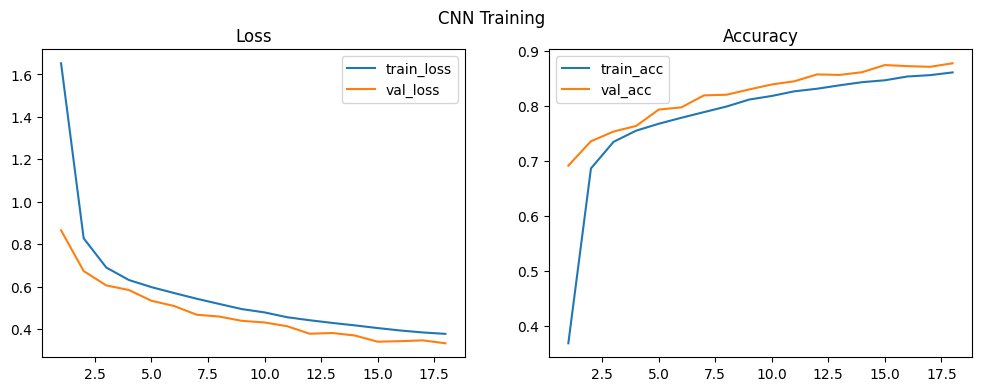

In [ ]:
# Cell 11: Train CNN(Convolutional neural network)
criterion = nn.CrossEntropyLoss()
cnn = SimpleCNN(activation='silu', dropout_p=0.3).to(device)
optimizer = optim.SGD(cnn.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

cnn_epochs = 18
history_cnn = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}
best_val_acc = 0
best_state = None

for epoch in range(1, cnn_epochs+1):
    train_loss, train_acc = train_one_epoch(cnn, train_loader_small, criterion, optimizer, device)
    val_loss, val_acc = evaluate(cnn, val_loader_small, criterion, device)
    scheduler.step(val_acc)
    history_cnn['train_loss'].append(train_loss); history_cnn['train_acc'].append(train_acc)
    history_cnn['val_loss'].append(val_loss); history_cnn['val_acc'].append(val_acc)
    print(f"[CNN] Epoch {epoch}/{cnn_epochs} -> train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = cnn.state_dict()

if best_state is not None:
    cnn.load_state_dict(best_state)

plot_train_val_curves(history_cnn, title='CNN Training')

CNN Test acc: 0.8759


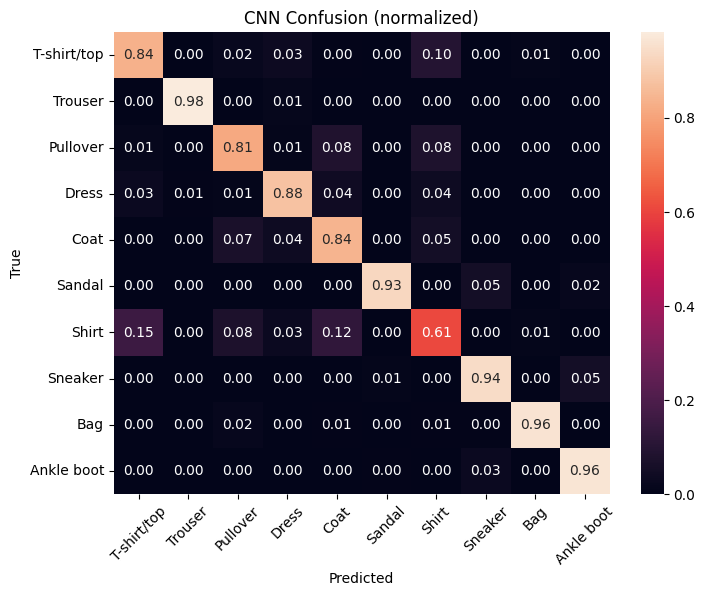

              precision    recall  f1-score   support

 T-shirt/top     0.8077    0.8360    0.8216      1000
     Trouser     0.9889    0.9820    0.9854      1000
    Pullover     0.8085    0.8150    0.8118      1000
       Dress     0.8736    0.8780    0.8758      1000
        Coat     0.7682    0.8420    0.8034      1000
      Sandal     0.9831    0.9320    0.9569      1000
       Shirt     0.6937    0.6070    0.6475      1000
     Sneaker     0.9171    0.9400    0.9284      1000
         Bag     0.9796    0.9620    0.9707      1000
  Ankle boot     0.9342    0.9650    0.9493      1000

    accuracy                         0.8759     10000
   macro avg     0.8755    0.8759    0.8751     10000
weighted avg     0.8755    0.8759    0.8751     10000



In [ ]:
# Cell 12: Evaluate CNN & Confusion metrics
test_loss_cnn, test_acc_cnn, y_pred_cnn, y_prob_cnn, y_true_cnn = evaluate(cnn, test_loader_small, criterion, device, return_preds=True)
print("CNN Test acc:", test_acc_cnn)
plot_confusion_matrix(y_true_cnn, y_pred_cnn, class_names, normalize=True, title='CNN Confusion (normalized)')
per_class_metrics(y_true_cnn, y_pred_cnn, class_names)


In [ ]:
# Cell 13: ConvNeXt-Tiny transfer learning(Add new model here)
# Robust loading across torchvision versions
try:
    # torchvision 0.13+ style
    convnext = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
except Exception:
    try:
        convnext = models.convnext_tiny(pretrained=True)
    except Exception as e:
        print("Warning: convnext_tiny pretrained load failed:", e)
        convnext = models.convnext_tiny(pretrained=False)

# Adjust first conv to accept 1-channel (grayscale)
# Different implementations store features differently; try common case:
try:
    w = convnext.features[0][0].weight.data  # shape (out, in, k, k)
    new_w = w.mean(dim=1, keepdim=True)
    convnext.features[0][0] = nn.Conv2d(1, convnext.features[0][0].out_channels,
                                        kernel_size=convnext.features[0][0].kernel_size,
                                        stride=convnext.features[0][0].stride,
                                        padding=convnext.features[0][0].padding,
                                        bias=False)
    convnext.features[0][0].weight.data = new_w
except Exception:
    # fallback: try to find conv in first module
    for m in convnext.modules():
        if isinstance(m, nn.Conv2d) and m.in_channels == 3:
            # re-create first conv
            new_conv = nn.Conv2d(1, m.out_channels, kernel_size=m.kernel_size, stride=m.stride, padding=m.padding, bias=False)
            # average weights from first 3 channels if possible
            try:
                old_w = m.weight.data
                new_conv.weight.data = old_w.mean(dim=1, keepdim=True)
                # assign back
                # This is a best-effort; not always necessary
            except Exception:
                pass
            break

# Replace classifier head for 10 classes
try:
    num_ftrs = convnext.classifier[2].in_features
    convnext.classifier[2] = nn.Linear(num_ftrs, 10)
except Exception:
    # fallback
    convnext.classifier = nn.Sequential(nn.LayerNorm(1000), nn.Linear(1000, 10))

convnext = convnext.to(device)
print("ConvNeXt-Tiny ready on", device)


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


100%|██████████| 109M/109M [00:00<00:00, 227MB/s] 


ConvNeXt-Tiny ready on cuda


/tmp/ipython-input-1838662801.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
/tmp/ipython-input-4165155882.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[ConvNeXt] Epoch 1/15 -> train_acc=0.8603, val_acc=0.9099, best_val=0.0000
[ConvNeXt] Epoch 2/15 -> train_acc=0.9153, val_acc=0.9101, best_val=0.9099
[ConvNeXt] Epoch 3/15 -> train_acc=0.9219, val_acc=0.9254, best_val=0.9101
[ConvNeXt] Epoch 4/15 -> train_acc=0.9279, val_acc=0.9229, best_val=0.9254
[ConvNeXt] Epoch 5/15 -> train_acc=0.9365, val_acc=0.9323, best_val=0.9254
[ConvNeXt] Epoch 6/15 -> train_acc=0.9426, val_acc=0.9305, best_val=0.9323
[ConvNeXt] Epoch 7/15 -> train_acc=0.9485, val_acc=0.9446, best_val=0.9323
[ConvNeXt] Epoch 8/15 -> train_acc=0.9575, val_acc=0.9423, best_val=0.9446
[ConvNeXt] Epoch 9/15 -> train_acc=0.9630, val_acc=0.9467, best_val=0.9446
[ConvNeXt] Epoch 10/15 -> train_acc=0.9712, val_acc=0.9444, best_val=0.9467
[ConvNeXt] Epoch 11/15 -> train_acc=0.9789, val_acc=0.9491, best_val=0.9467
[ConvNeXt] Epoch 12/15 -> train_acc=0.9840, val_acc=0.9522, best_val=0.9491
[ConvNeXt] Epoch 13/15 -> train_acc=0.9890, val_acc=0.9532, best_val=0.9522
[ConvNeXt] Epoch 14/1

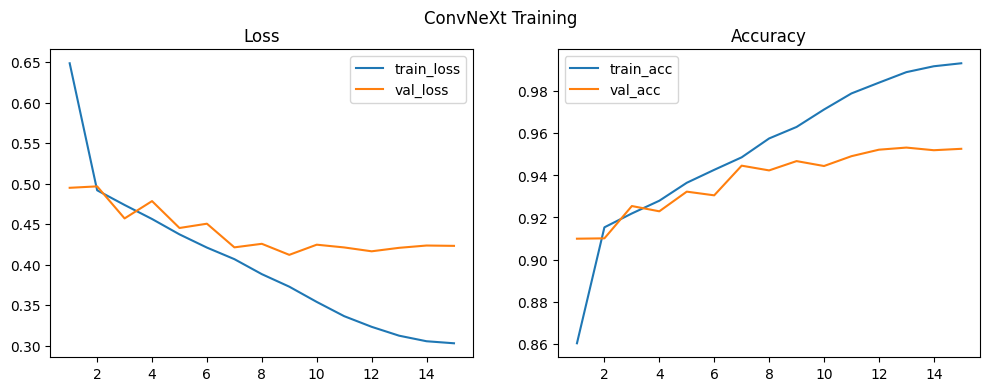

In [ ]:
# Cell 14: Train ConvNeXt-Tiny with OneCycleLR and mixed precision
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
# Freeze early layers optionally
for name, param in convnext.named_parameters():
    param.requires_grad = True  # if you want to freeze, set some to False here

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, convnext.parameters()), lr=2e-4, weight_decay=1e-4)

steps_per_epoch = len(train_loader_conv)
conv_epochs = 15
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=3e-4, epochs=conv_epochs, steps_per_epoch=steps_per_epoch,
    pct_start=0.25, anneal_strategy='cos', div_factor=10, final_div_factor=100
)

scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

history_conv = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}
best_val_acc = 0
best_state = None

for epoch in range(1, conv_epochs+1):
    train_loss, train_acc = train_one_epoch(convnext, train_loader_conv, criterion, optimizer, device, scaler=scaler, scheduler=scheduler)
    val_loss, val_acc = evaluate(convnext, val_loader_conv, criterion, device)
    history_conv['train_loss'].append(train_loss); history_conv['train_acc'].append(train_acc)
    history_conv['val_loss'].append(val_loss); history_conv['val_acc'].append(val_acc)
    print(f"[ConvNeXt] Epoch {epoch}/{conv_epochs} -> train_acc={train_acc:.4f}, val_acc={val_acc:.4f}, best_val={best_val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = convnext.state_dict()

if best_state is not None:
    convnext.load_state_dict(best_state)

plot_train_val_curves(history_conv, title='ConvNeXt Training')


ConvNeXt Test acc: 0.954


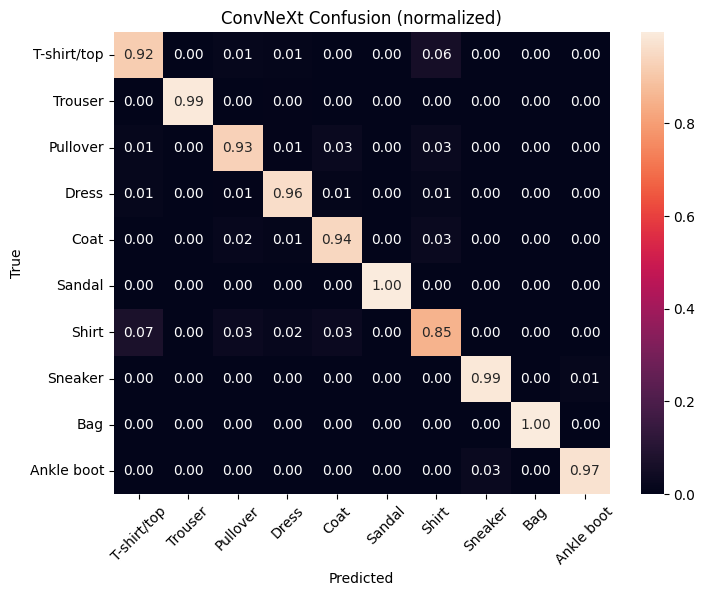

              precision    recall  f1-score   support

 T-shirt/top     0.9018    0.9180    0.9098      1000
     Trouser     0.9980    0.9910    0.9945      1000
    Pullover     0.9327    0.9290    0.9309      1000
       Dress     0.9543    0.9600    0.9571      1000
        Coat     0.9338    0.9450    0.9394      1000
      Sandal     0.9950    0.9960    0.9955      1000
       Shirt     0.8735    0.8490    0.8611      1000
     Sneaker     0.9705    0.9860    0.9782      1000
         Bag     0.9950    0.9960    0.9955      1000
  Ankle boot     0.9848    0.9700    0.9773      1000

    accuracy                         0.9540     10000
   macro avg     0.9539    0.9540    0.9539     10000
weighted avg     0.9539    0.9540    0.9539     10000



In [ ]:
# Cell 15: Evaluate ConvNeXt & confusion metrics
test_loss_conv, test_acc_conv, y_pred_conv, y_prob_conv, y_true_conv = evaluate(convnext, test_loader_conv, criterion, device, return_preds=True)
print("ConvNeXt Test acc:", test_acc_conv)
plot_confusion_matrix(y_true_conv, y_pred_conv, class_names, normalize=True, title='ConvNeXt Confusion (normalized)')
per_class_metrics(y_true_conv, y_pred_conv, class_names)


Top confused pairs (ConvNeXt): [('Shirt', 'T-shirt/top', 71), ('T-shirt/top', 'Shirt', 57), ('Shirt', 'Coat', 30)]
ConvNeXt: found 128 confused samples for ('Shirt', 'T-shirt/top')


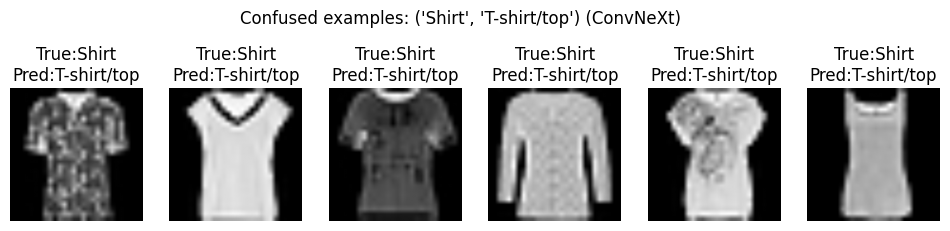

In [ ]:
# Cell 16: Visual confusion analysis (shirt vs coat + top confused pairs)
import random

def most_confused_pairs(y_true, y_pred, classes, top_k=3):
    cm = confusion_matrix(y_true, y_pred)
    np.fill_diagonal(cm, 0)
    flat = cm.flatten()
    top_indices = np.argsort(flat)[::-1][:top_k]
    pairs = []
    for idx in top_indices:
        i, j = divmod(idx, len(classes))
        pairs.append((classes[i], classes[j], int(cm[i, j])))
    return pairs

def show_confused_samples(model_name, y_true, y_pred, dataset, classes, class_pair=("Shirt","Coat"), n_samples=6):
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    if class_pair[0] not in classes or class_pair[1] not in classes:
        raise ValueError("class_pair not in classes")
    a = classes.index(class_pair[0]); b = classes.index(class_pair[1])
    idxs = list(np.where((y_true==a)&(y_pred==b))[0]) + list(np.where((y_true==b)&(y_pred==a))[0])
    print(f"{model_name}: found {len(idxs)} confused samples for {class_pair}")
    if len(idxs)==0:
        return
    sample_idxs = random.sample(idxs, min(n_samples, len(idxs)))
    plt.figure(figsize=(12,3))
    for i, idx in enumerate(sample_idxs):
        img, _ = dataset[idx]
        img_to_plot = img.squeeze().cpu().numpy()
        plt.subplot(1, len(sample_idxs), i+1)
        plt.imshow(img_to_plot, cmap='gray')
        plt.title(f"True:{classes[y_true[idx]]}\nPred:{classes[y_pred[idx]]}")
        plt.axis('off')
    plt.suptitle(f"Confused examples: {class_pair} ({model_name})")
    plt.show()

# Top confused pairs for ConvNeXt
pairs = most_confused_pairs(y_true_conv, y_pred_conv, class_names, top_k=3)
print("Top confused pairs (ConvNeXt):", pairs)
# Visualize the top pair
if len(pairs)>0:
    top_pair = (pairs[0][0], pairs[0][1])
    # use test_dataset_convnext to get resized images
    show_confused_samples("ConvNeXt", y_true_conv, y_pred_conv, test_dataset_convnext, class_names, class_pair=top_pair, n_samples=6)


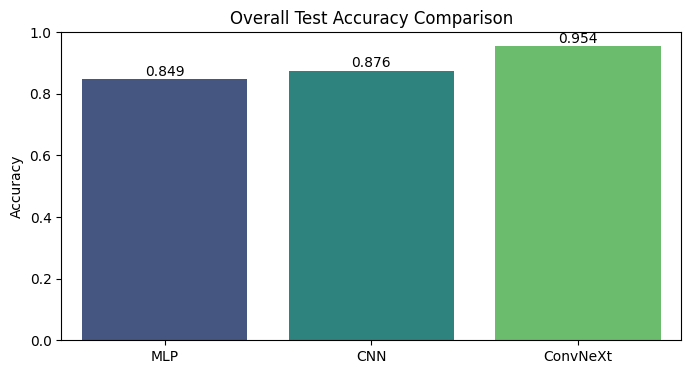

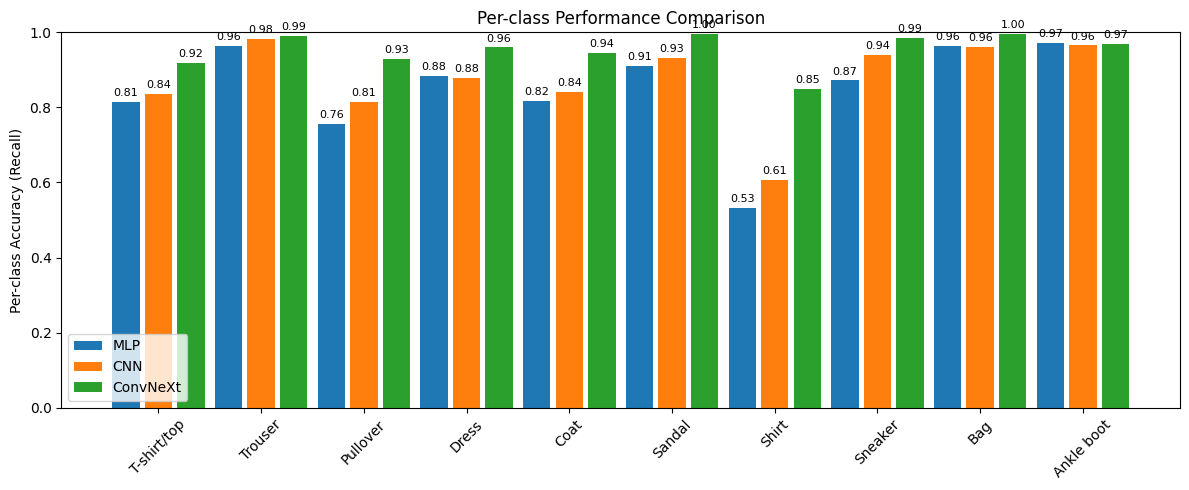

In [ ]:
# Comparison charts of (overall & per-class grouped bars)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- Overall accuracy comparison ---
models_present = []
accuracies_present = []

if 'test_acc_mlp' in globals():
    models_present.append('MLP')
    accuracies_present.append(test_acc_mlp)
if 'test_acc_cnn' in globals():
    models_present.append('CNN')
    accuracies_present.append(test_acc_cnn)
if 'test_acc_conv' in globals():
    models_present.append('ConvNeXt')
    accuracies_present.append(test_acc_conv)

# Plot overall accuracies
if models_present:
    plt.figure(figsize=(8,4))
    sns.barplot(x=models_present, y=accuracies_present, hue=models_present, palette="viridis", legend=False)
    plt.ylim(0, 1)
    plt.title('Overall Test Accuracy Comparison')
    plt.ylabel('Accuracy')
    for i, v in enumerate(accuracies_present):
        plt.text(i, v + 0.01, f"{v:.3f}", ha='center', fontsize=10)
    plt.show()
else:
    print("No accuracies to plot.")

# --- Per-class grouped bar chart ---
def per_class_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    with np.errstate(divide='ignore', invalid='ignore'):
        per = cm.diagonal() / cm.sum(axis=1)
        per[np.isnan(per)] = 0
    return per.flatten()  # ensure 1D array

per_class_results = {}
if 'y_true_mlp' in globals() and 'y_pred_mlp' in globals():
    per_class_results['MLP'] = per_class_accuracy(y_true_mlp, y_pred_mlp)
if 'y_true_cnn' in globals() and 'y_pred_cnn' in globals():
    per_class_results['CNN'] = per_class_accuracy(y_true_cnn, y_pred_cnn)
if 'y_true_conv' in globals() and 'y_pred_conv' in globals():
    per_class_results['ConvNeXt'] = per_class_accuracy(y_true_conv, y_pred_conv)

if per_class_results:
    n_classes = len(class_names)
    n_models = len(per_class_results)
    x = np.arange(n_classes)
    width = 0.8 / max(1, n_models)

    plt.figure(figsize=(12,5))
    for i, (model, accs) in enumerate(per_class_results.items()):
        # Add a small offset between groups
        bars = plt.bar(x + i*(width + 0.05), accs, width=width, label=model)
        # Add numeric labels
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}",
                     va='bottom', ha='center', fontsize=8)

    plt.xticks(x + (width + 0.05)*(n_models-1)/2, class_names, rotation=45)
    plt.ylim(0, 1)
    plt.ylabel('Per-class Accuracy (Recall)')
    plt.title('Per-class Performance Comparison')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No per-class metrics to plot.")


In [ ]:
# Cell 18: Save best models
os.makedirs('models', exist_ok=True)
if 'mlp' in globals(): torch.save(mlp.state_dict(), 'models/mlp_best.pth')
if 'cnn' in globals(): torch.save(cnn.state_dict(), 'models/cnn_best.pth')
if 'convnext' in globals(): torch.save(convnext.state_dict(), 'models/convnext_best.pth')
print("Saved models to ./models")


Saved models to ./models
